# Introduction to single-cell multi-view profiler (scMVP)
In this introductory tutorial, we present the different tasks of a scMVP workflow
1. Loading the multi-omics data
2. Training the multi-view model
3. Retrieving the common latent space and imputed multi-omics values
4. Perform cell clustering and differential expression 
5. Visualize the common latent space and clustering with umap

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scMVP.dataset import LoadData,GeneExpressionDataset, CellMeasurement
from scMVP.models import VAE_Attention, Multi_VAE_Attention, VAE_Peak_SelfAttention
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
import torch

import scanpy as sc
import anndata

import scipy.io as sp_io
from scipy.sparse import csr_matrix, issparse



[2023-05-27 18:30:48,133] INFO - scMVP._settings | Added StreamHandler with custom formatter to 'scMVP' logger.
/data1/xcx/anaconda3/envs/scMVP/lib/python3.7/site-packages/scikit_learn-0.22.2-py3.7-linux-x86_64.egg/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [12]:
# If your PC do not have GPU, your can use multi threads to accelerate the training 
torch.set_num_threads(40) # do not use all CPU threads

## Step1: Loading data

 loading the sci-CAR cell line dataset described in Junyue Cao et al. (2018).

* Junyue Cao, et al. "Joint profiling of chromatin accessibility and gene 
expression in thousands of single cells." Science 361.6409 (2018): 1380-1385. 
<br>

You can also downloaded processed input in **README.md.**

In [4]:
input_path = "/home/xcx/MYBenchmark-codes/5-scMVP/download/"
output_path = "/home/xcx/MYBenchmark-codes/5-scMVP/download/scMVP_output"

sciCAR_cellline_dataset = {
                "gene_names": 'snare_p0_scale_gene.txt',
                "gene_expression": 'snare_p0_rna_normalize_count.mtx',
                "gene_barcodes": 'snare_p0_cell_barcode.txt',
                "atac_names": 'snare_p0_peak.txt',
                "atac_expression": 'snare_p0_atac_normalize_count.mtx',
                "atac_barcodes": 'snare_p0_cell_barcode.txt'
                }

dataset = LoadData(dataset=sciCAR_cellline_dataset,data_path=input_path,
                       dense=False,gzipped=False, atac_threshold=0.001,
                       cell_threshold=1)

# input_path = "/home/xcx/datas/SNARE-seq-GSE126074/_Cellline/"
# output_path = "/home/xcx/codes/scMVP-master/data/snare-seq-1000/scMVP_output"

# snare_p0_dataset = {
#                 "gene_expression": "GSE126074_CellLineMixture_SNAREseq_cDNA_counts.tsv",
#                 "atac_expression": "GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv"
#                 }
# dataset = LoadData(dataset=snare_p0_dataset,data_path=input_path,
#                        dense=False,gzipped=False, atac_threshold=0.0005, file_separator = ",",
#                        cell_threshold=1)

# input_path = "/home/xcx/codes/scMVP-master/data/snare-seq-1000/"
# output_path = "/home/xcx/codes/scMVP-master/data/snare-seq-1000/scMVP_output"

# snare_p0_dataset = {
#                 "gene_expression": "new_counts_rna.csv",
#                 "atac_expression": "new_counts_atac.csv"
#                 }
# dataset = LoadData(dataset=snare_p0_dataset,data_path=input_path,
#                        dense=False,gzipped=False, atac_threshold=0.0005, file_separator = ",",
#                        cell_threshold=1)

[2023-05-27 18:35:17,913] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2023-05-27 18:35:56,145] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2023-05-27 18:35:56,291] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-27 18:35:56,293] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2023-05-27 18:36:09,045] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2023-05-27 18:36:09,115] INFO - scMVP.dataset.dataset | Downsampled from 5081 to 5081 cells


In [2]:
import scanpy as sc

rna = sc.read("/home/xcx/MYBenchmark-codes/5-scMVP/download/snare_p0_rna_normalize_count.mtx", cache = True)
atac = sc.read("/home/xcx/MYBenchmark-codes/5-scMVP/download/snare_p0_atac_normalize_count.mtx", cache = True)

## Step2: train your scMVP model, and get trained output

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA (GPU required) 
* __n_centroids__: Set the number of cell types
* __n_alfa__: Set the weight of KL loss

In [9]:
n_epochs = 10
lr = 5e-3
use_batches = False
use_cuda = True # False if using CPU
n_centroids = 15 
n_alfa = 1.0

multi_vae = Multi_VAE_Attention(dataset.nb_genes, len(dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

if os.path.exists("{}/multi_vae_trainer.pkl".format(output_path)):
    trainer.model.load_state_dict(torch.load("{}/multi_vae_trainer.pkl".format(output_path)))
else:
    # around 1-3 min on 1080Ti
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer.pkl' % output_path)


RuntimeError: Error(s) in loading state_dict for Multi_VAE_Attention:
	Missing key(s) in state_dict: "ATAC_encoder.layernorm.weight", "ATAC_encoder.layernorm.bias". 
	Unexpected key(s) in state_dict: "RNA_ATAC_decoder.layernorm.weight", "RNA_ATAC_decoder.layernorm.bias". 

In [16]:
# create posterior from trained model
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

# # UMAP visulization
# prior_adata = anndata.AnnData(X=latent)
# cell_embeddings = pd.read_csv(input_path+'anno.txt', sep="\t",index_col=0).iloc[:,[3,4,5]]
# prior_adata.obs['cell_type'] = cell_embeddings.loc[dataset.barcodes,"labels"].to_list()
# prior_adata.obsm["X_multi_vi"] = latent

# # louvain cluster
# sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
# sc.tl.umap(prior_adata, min_dist=0.3)
# sc.tl.louvain(prior_adata)
# sc.pl.umap(prior_adata, color=['louvain'])
# plt.show()

# # origin cell label
# sc.pl.umap(prior_adata, color=['cell_type'])
# plt.show()

# # Kmeans cluster
# from sklearn.cluster import KMeans
# latent_code = prior_adata.obsm["X_multi_vi"]

# kmeans = KMeans(n_clusters=3, random_state=0).fit(latent_code) 
# prior_adata.obs['kmeans'] = kmeans.labels_.astype(str)
# sc.pl.umap(prior_adata, color=['kmeans'])
# plt.show()

In [17]:
print(latent)
print(latent_rna)
print(latent_atac)
# print(cluster_gamma)
# print(cluster_index)
# print(batch_indices)
# print(labels)

# print(type(latent))
# print(type(latent_rna))
# print(type(latent_atac))
# print(type(cluster_gamma))
# print(type(cluster_index))
# print(type(batch_indices))
# print(type(labels))

print(latent.shape)
print(latent_rna.shape)
print(latent_atac.shape)
# print(cluster_gamma.shape)
# print(cluster_index.shape)
# print(batch_indices.shape)
# print(labels.shape)

# print(np.bincount(cluster_index))
# print(np.bincount(batch_indices))

[[ 0.36188596 -0.6186729  -0.27129903 ...  0.44361377 -0.71505314
  -0.3070975 ]
 [ 0.39497116 -0.38211256 -0.03171968 ...  0.37617847 -0.60227567
  -0.29541254]
 [ 0.4503932   0.01405465 -0.31212178 ...  0.54719806 -0.5461578
  -0.278647  ]
 ...
 [ 0.44540888 -0.41705987 -0.02555162 ...  0.5617182  -0.7849639
  -0.07757261]
 [ 0.44348022 -0.32500985 -0.23516838 ...  0.5732737  -0.1236788
  -0.33239263]
 [ 0.32385388 -0.3446857  -0.25908265 ...  0.42979255 -0.23944461
  -0.2541652 ]]
[[ 0.4367488   0.9917912  -0.7462102  ... -0.09929986  0.00850422
  -0.4645379 ]
 [ 0.55248004  0.5626214  -0.22249383 ... -0.21371879  0.0450914
  -0.2093415 ]
 [ 0.777865    0.7818801  -0.57616514 ...  0.07572047  0.12973857
   0.10526683]
 ...
 [ 0.6881649   0.68765455 -0.5846432  ...  0.03304112  0.16805439
   0.09261043]
 [ 0.48051515  0.5697381  -0.20754021 ...  0.200479    0.29382828
   0.3022371 ]
 [ 0.6318453   0.5521326  -0.37177616 ... -0.09491234  0.02492023
  -0.03211045]]
[[ 0.3500855   0.547

In [ ]:
# save all output to files
# 1. 20-diemension joint latent embedding of scMVP
df = pd.DataFrame(data=prior_adata.obsm["X_multi_vi"],  index=rna_dataset.barcodes)
df.to_csv(os.path.join(output_path,"multivae_latent_imputation.csv"))

# 2. 2-diemension UMAP visualization
df = pd.DataFrame(data=prior_adata.obsm["X_umap"], 
                  columns=["umap_dim1","umap_dim2"] , index=rna_dataset.barcodes)
# add label columns
df.insert(0,"kmeans",prior_adata.obs['kmeans'].values)
df.to_csv(os.path.join(output_path,"multivae_umap.csv"))

# 3. whole scATAC imputations and scRNA imputations. It will took really long time if the scATAC dataset is very large.
df = pd.DataFrame(data=imputed_values[1].T, columns=rna_dataset.barcodes, index=rna_dataset.atac_names)
df.to_csv(os.path.join(output_path,"atac_multivae_imputation.csv"))

df = pd.DataFrame(data=imputed_values[0].T, columns=rna_dataset.barcodes, index=rna_dataset.gene_names)
df.to_csv(os.path.join(output_path,"gene_multivae_imputation.csv"))

## Step3: Perform differential analysis
Here, we demostrate two DE contrasts of A549_1h/A549_0h and A549_3h/A549_0h.   
You can change the DE groups as one cell type versus all other cell types.

In [8]:
# Differential gene analysis
posterior_adata = anndata.AnnData(X=imputed_values[0])
posterior_adata.var = pd.DataFrame(index=dataset.gene_names.reshape(-1))
posterior_adata.obsm["X_multi_vi"] = latent
posterior_adata.obs['cell_type'] =  cell_embeddings.loc[dataset.barcodes,"labels"].to_list()
sc.tl.rank_genes_groups(posterior_adata, 'cell_type', group=["A549_1h","A549_3h"],reference="A549_0h")
df_tab=sc.get.rank_genes_groups_df(posterior_adata, group=["A549_1h","A549_3h"])
df_tab.to_csv("{}/sciCAR_A549_DEG_tutorial.csv".format(output_path),index=False)

... storing 'cell_type' as categorical


## (Optional) Pre-training
- For large and complex realistic joint profiling dataset like SHARE-seq skin dataset, we recommend to perform pre-training before scMVP training.

- We next give a demo for pretraining of scRNA and scATAC, and then perform scMVP training.

### Step1: Construct separate dataset obeject

In [10]:
atac_dataset = GeneExpressionDataset()
cell_attributes_dict = {
    "barcodes": dataset.barcodes
    }
atac_dataset.populate_from_data(
    X=dataset.atac_expression, # notice the normalization
    batch_indices=None,
    gene_names=dataset.atac_names,
    cell_attributes_dict=cell_attributes_dict,
    Ys=[],
)
rna_dataset = GeneExpressionDataset()
Ys = []
measurement = CellMeasurement(
        name="atac_expression",
        data=atac_dataset.X,
        columns_attr_name="atac_names",
        columns=atac_dataset.gene_names,
    )
Ys.append(measurement)
cell_attributes_dict = {
    "barcodes": dataset.barcodes
    }
rna_dataset.populate_from_data(
    X=dataset.X,
    batch_indices=None,
    gene_names=dataset.gene_names,
    cell_attributes_dict=cell_attributes_dict,
    Ys=Ys,
)

[2023-05-27 19:27:51,208] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-27 19:27:51,243] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2023-05-27 19:27:51,363] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-27 19:27:51,365] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]


### Step2: Pretrain and visualize ATAC dataset
(approximate 1min on 1080Ti)

In [11]:
# ATAC pretraining
pre_atac_vae = VAE_Peak_SelfAttention(atac_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_atac_trainer = UnsupervisedTrainer(
    pre_atac_vae,
    atac_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

if os.path.isfile('%s/pre_atac_trainer.pkl' % output_path):
    pre_atac_trainer.model.load_state_dict(torch.load('%s/pre_atac_trainer.pkl' % output_path))
    pre_atac_trainer.model.eval()
else:
    pre_atac_trainer.train(n_epochs=15, lr=lr)
    torch.save(pre_atac_trainer.model.state_dict(), '%s/pre_atac_trainer.pkl' % output_path)
    pre_atac_trainer.model.eval()


RuntimeError: Error(s) in loading state_dict for VAE_Peak_SelfAttention:
	Missing key(s) in state_dict: "z_encoder.layernorm.weight", "z_encoder.layernorm.bias". 

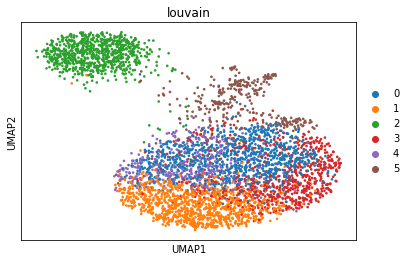

In [13]:
# ATAC pretrainer_posterior:
full = pre_atac_trainer.create_posterior(pre_atac_trainer.model, atac_dataset, indices=np.arange(len(atac_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
prior_adata = anndata.AnnData(X=atac_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

### Step3: Perform similar pretraining for scRNA dataset
(less than 1min)

training:   0%|          | 0/10 [00:00<?, ?it/s]reconst_loss=3372.981445, kl_divergence=0.790359
tensor(3373.9817, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=3184.722168, kl_divergence=1.100110
tensor(3185.7224, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=3086.594238, kl_divergence=1.290236
tensor(3087.5945, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=3130.473877, kl_divergence=1.682800
tensor(3131.4741, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=3069.042969, kl_divergence=2.134964
tensor(3070.0432, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2891.648438, kl_divergence=2.135544
tensor(2892.6487, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=3107.014160, kl_divergence=2.680740
tensor(3108.0144, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=3061.668945, kl_divergence=3.302228
tensor(3062.6689, device='cuda:0', grad_fn=<DivBackward0>)
reconst_loss=2909.187500, kl_divergence=3.099576
tensor(2910.1875, device='cuda:0', grad

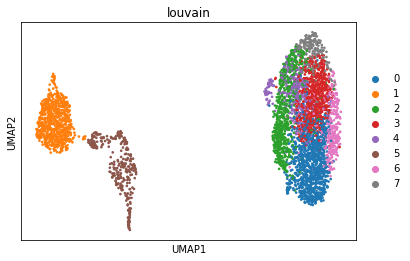

In [15]:
# RNA embedding
pre_vae = VAE_Attention(rna_dataset.nb_genes, n_latent=20,n_batch=0, n_layers=1, log_variational=True, reconstruction_loss="nb")
pre_trainer = UnsupervisedTrainer(
    pre_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=True,
    frequency=5,
)


if os.path.isfile('%s/pre_trainer_tutorial.pkl' % output_path):
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer_tutorial.pkl' % output_path))
    pre_trainer.model.eval()

else:
    pre_trainer.train(n_epochs=10, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/pre_trainer_tutorial.pkl' % output_path)
    pre_trainer.model.eval()


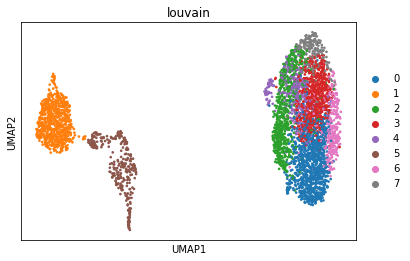

In [16]:
# RNA pretrainer_posterior:
full = pre_trainer.create_posterior(pre_trainer.model, rna_dataset, indices=np.arange(len(rna_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

# UMAP visulization
prior_adata = anndata.AnnData(X=rna_dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = torch.tensor(labels.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

### Step4:  Perform scMVP training with two pretrained models
(few minutes)

In [17]:
# get n_centroids from scRNA data
n_centroids=len(np.unique(prior_adata.obs['louvain'].tolist()))


multi_vae = Multi_VAE_Attention(rna_dataset.nb_genes, len(rna_dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    rna_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)


if os.path.isfile('%s/multi_vae_trainer_tutorial2.pkl' % output_path):
    trainer.model.load_state_dict(torch.load('%s/multi_vae_trainer_tutorial2.pkl' % output_path))
    trainer.model.eval()
else:
    pre_trainer = UnsupervisedTrainer(
        pre_vae,
        rna_dataset,
        train_size=0.9,
        use_cuda=use_cuda,
        frequency=5,
    )
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer_tutorial.pkl' % output_path))

    pre_atac_trainer = UnsupervisedTrainer(
        pre_atac_vae,
        atac_dataset,
        train_size=0.9,
        use_cuda=use_cuda,
        frequency=5,
    )
    pre_atac_trainer.model.load_state_dict(torch.load('%s/pre_atac_trainer_tutorial.pkl' % output_path))

    n_centroids=len(np.unique(prior_adata.obs['louvain'].tolist()))

    # joint RNA and ATAC embedding
    trainer.model.init_gmm_params_with_louvain(latent,np.array(prior_adata.obs['louvain'].tolist()).astype(int))

    trainer.model.RNA_encoder.load_state_dict(pre_trainer.model.z_encoder.state_dict())
    for param in trainer.model.RNA_encoder.parameters():
        param.requires_grad = True
    trainer.model.ATAC_encoder.load_state_dict(pre_atac_trainer.model.z_encoder.state_dict())
    for param in trainer.model.ATAC_encoder.parameters():
        param.requires_grad = True
    trainer.train(n_epochs=15, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer_tutorial2.pkl' % output_path)
    trainer.model.eval()

training:   0%|          | 0/15 [00:00<?, ?it/s]logpzc:-205.41561889648438, logqcx:-2.079441547393799
kld_qz_pz = 165.758743,kld_qz_rna = 18467.853516,kld_qz_atac = 4801.834961,kl_divergence = 17417.916016,reconst_loss_rna = 9533.786133,        reconst_loss_atac = 222.985657, mu=0.388228, sigma=0.878287
reconst_loss = 9807.140625,kl_divergence_local = 17417.916016,kl_weight = 1.000000,loss = 27225.054688
tensor(27225.0547, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-1207.67236328125, logqcx:-2.079441547393799
kld_qz_pz = 1166.077271,kld_qz_rna = 21609.318359,kld_qz_atac = 5748.049805,kl_divergence = 1203.720337,reconst_loss_rna = 9793.573242,        reconst_loss_atac = 213.483292, mu=0.388117, sigma=0.879255
reconst_loss = 10057.423828,kl_divergence_local = 1203.720337,kl_weight = 1.000000,loss = 11261.144531
tensor(11261.1445, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-278.04437255859375, logqcx:-2.079441547393799
kld_qz_pz = 236.838409,kld_qz_rna = 21058.574219,kld_qz_atac

In [ ]:
#### Then same with direct scMVP training

In [ ]:
# create posterior from trained model
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

# UMAP visulization
prior_adata = anndata.AnnData(X=latent)
cell_embeddings = pd.read_csv(input_path+'sciCAR_cell_annot.txt', sep="\t",index_col=0).iloc[:,[3,4,5]]
prior_adata.obs['cell_type'] = cell_embeddings.loc[dataset.barcodes,"labels"].to_list()
prior_adata.obsm["X_multi_vi"] = latent

# louvain cluster
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)
sc.tl.louvain(prior_adata)
sc.pl.umap(prior_adata, color=['louvain'])
plt.show()

# origin cell label
sc.pl.umap(prior_adata, color=['cell_type'])
plt.show()

# Kmeans cluster
from sklearn.cluster import KMeans
latent_code = prior_adata.obsm["X_multi_vi"]

kmeans = KMeans(n_clusters=3, random_state=0).fit(latent_code) 
prior_adata.obs['kmeans'] = kmeans.labels_.astype(str)
sc.pl.umap(prior_adata, color=['kmeans'])
plt.show()